## <a id = "ToC">Table Of Contents</a>
1. [What is Churn?](#step1)
2. [Data Exploration](#step2)   
    2.1 [Categorical Features](#step2.2)  
    2.2 [More on categorical anagraphical features (Apriori algorithm)](#step2.1)  
    2.3 [Numerical Features](#step2.3)
3. [Feature Engineering](#step3)
3. [Dealing with imbalance](#step4)
3. [Decision Tree Modeling](#step5)
3. [XGBoost Modeling](#step6)  
    3.1 [XGBoost Explanation](#step6.1)

## <a id = "step1">What is Churn?</a>

<a style="font-size:12px;" href="#ToC">Back to Table of Contents</a>
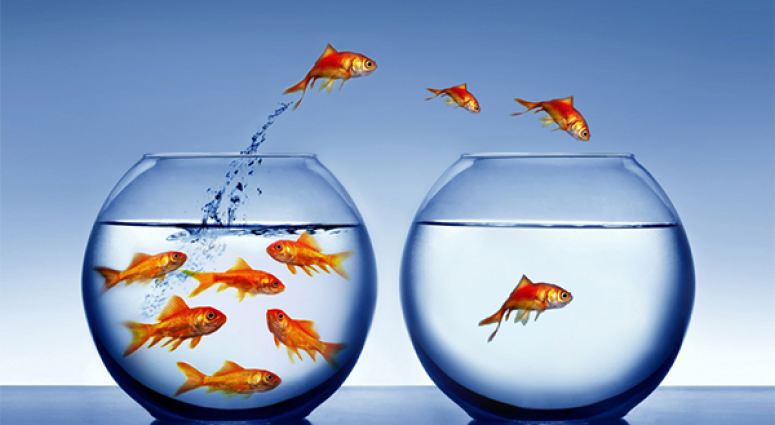

`Customer attrition, also known as customer churn, customer turnover, or customer defection, is the loss of clients or customers.` ([Wikipedia](https://en.wikipedia.org/wiki/Customer_attrition))

Hence, customers are said to be *attrited* or *churned* when they quit their relationship with the provider (the bank, in this particular project). This is a broad definition and it might change from company to company. Churned clients are not only clients with a closed account indeed, but also those ones with an open but *inactive* account. 

> Why do we care about churning?
* `reducing customer churn by 5% can increase profits 25–125%`;
* it is estimated that `It costs 5 times more to acquire new customers than it does to keep the current ones`;

These two simple lines underlines that it is crucial for a company to have as many loyal customers as possible and to detect all possible causes of attrition and prone-to-churn clients.

For this reasons, *interpretability* of the Machine Learning results is the main focus in this notebook. Having an outstanding Machine Learning pipeline is useless, if no business intuition or decision can be based on its results.

**Sources:**
- [What is Customer Churn & How to Reduce It?](https://medium.com/@paldesk/what-is-customer-churn-how-to-reduce-it-402460e5b569)
- [Retain more customers by understanding churn](https://medium.com/data-science-at-microsoft/retain-more-customers-by-understanding-churn-ae31d9b2aa2b)

<a size="8"><b>What is this notebook about?</b></a>  
The project is based on a classification framework, since data comes with an *Attrition Flag* binary attribute. However, as stated above, it is key for this framework to be interpretable. For this reason, two approaches are developed:
1. building an interpretable model by contruction (a decision tree);
2. build an explainable AI pipeline (through SHAP algorithm) to make a black box model (XGBoost) easy to understand.

### Import Libraries

In [ ]:
# 1. Standard libraries

from pathlib import Path

# 2. Third Party Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

# 2.1 EDA of categorical anagraphical features

from mlxtend.frequent_patterns import apriori, association_rules
from scipy.stats import ttest_ind, chi2_contingency

# 2.2 Imbalance handling

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling  import RandomUnderSampler
from imblearn.pipeline import Pipeline

# 2.3 Machine Learning

from sklearn.metrics import confusion_matrix, f1_score, fbeta_score, accuracy_score, plot_confusion_matrix
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
from xgboost import XGBClassifier
import graphviz

# 2.4 Explainable AI

import shap

## <a id = "step2">Data Exploration</a>
<a style="font-size:12px;" href="#ToC">Back to Table of Contents</a>

<span style="font-size:16px;color:Green"><b>INTRODUCTION</b></span>

The purpose of this section is to become acquainted with the dataset.Two main needs have to be taken into account:
1. understand what kind of variables are inside the dataset and what is their meaning. Functional knowledge allows to create new variables and get insights from our machine learning output;
2. get insights that could bring to better output results, such as which variable are related to the target variable or with each other. This is the stepping stone for a good model, since it allows to select the right number of variables (avoiding useless or correlated features) in agreement with Occam's razor principle;  

<span style="font-size:16px;color:Green"><b>RESULTS:</b></span>

In the dataset we can find three main classes of features:
* **anagraphical features:** *Customer_Age, Gender, Education_Level, Marital_Status, Income_Category*. Their meaning is straightforward;
* **customer-bank relationship features:** 
    - Dependent_count: [number of people uses that specific account](https://www.kaggle.com/sakshigoyal7/credit-card-customers/discussion/201767);
    - Card_Category: is this a Premium or a Basic account?
    - Months_on_book: the duration of the relationship as of now;
    - Total_Relationship_Count: Total number of products held by the customer. In other words, client could have other productslike debit card, loans, and so on;
    - Contacts_Count_12_mon: the number of contacts between the customer and the bank in the last 12 months. It could be a key indicator of the satisfaction level of the client: the more contacts, the higher the probability that there is something that causes attrition;
* **Credit Card utilization features:**
    - Months_Inactive: it determines how many months the client has been inactive. However this variable is not entirely clear to me: official documentation states that this inactivity status is recorded among the last 12 months. However the highest value of this variable is 6 and it is not clear whether this is the number of *consecutive* months of inactivity. In my personal opinion, this variable shows the maximum number of consecutive months of inactivity and a customer is classified as *churned* after 6 or 7 months of inactivity;
    - Credit_Limit: this is the maximum amount the client is allowed to use;
    - Total_Revolving_Bal: the debt amount. For example the revolving balance value in february is determined by: $$Debt\_February=Debt\_January+CreditUsed\_February-DebtPaid\_February$$
    - Avg_Open_To_Buy: suppose a client has used 500£, and its credit limit is 2500£. The custormer is thus *open to buy* 2500-500=2000£. Avg_Open_To_Buy is the average over the last 12 months of the Open To Buy value;
    - Total_Trans_Amt: total transactional amount in the last 12 months;
    - Total_Amt_Chng_Q4_Q1: the ratio between transactional amount of first quarter and the same amount for fourth quarter. Hence, a value smaller tha 1 means that the customer has spent less in this quarter with respect to the last one;
    - Total_Trans_Ct, Total_Ct_Chng_Q4_Q1: their meaning is analogous to the last two variables. Of course, thee differ on the underlying reference variable, since in this case it is the number of transactions instead of the amount;
    - Avg_Utilization_Ratio: $$Utilization\_Ratio=\frac{Credit\_Limit-Open\_To\_Buy}{Credit\_Limit}=\frac{Credit\_Used}{Credit\_Limit}$$
    Avg_Utilization_Ratio is the average proportion of the credit used with respect to the credit liit in the last 12 months.

There are two more features:
* **CLIENTNUM:** primary key of the dataset. For the sake of the project, it is not useful;
* **Attrition_Flag:** whether the customer is an attrited one or not. Attrited customer are referred to *closed* accounts, thus there might be clients *near to churn* in the dataset but classified as normal clients (this will cause some errors, like we will see below).  
[Here](#anchorAttrition) you can see the distribution of this variable. We can observe that it is an unbalanced distribution (about 84% of the data belong to the class *Existing Customer*, whereas only 16% of clients are in the class of churned ones). This means that any standard machine learning algorithm will struggle to classify correctly the minority class. For more on this, please refer to [section 4](#step4);



For in depth insights for each variable, please refer to:
* [Categorical Variables subsection](#step2.2)
* [Numerical Variables subsection](#step2.3)

In [ ]:
df = pd.read_csv("../input/credit-card-customers/BankChurners.csv")
df.drop(df.columns[[-2, -1]], axis = 1, inplace = True) # deleting last two columns as suggested

pd.set_option("display.max_columns", 21)
display(df.head())
pd.reset_option("display.max_columns")

Let's have a look at some attritioned customers. It is possible to notice that most of them have a very low utilization ratio and their Transaction Amount (both as number of activities and value) has decreased with respect to the last quarter.

In [ ]:
pd.set_option("display.max_columns", 21)

display(df[df.Attrition_Flag == "Attrited Customer"].sample(5, random_state = 4))

pd.reset_option("display.max_columns")

**Basic Info**

In [ ]:
print(f"The dataset has {df.shape[0]} rows and {df.shape[1]} columns")
print("\n\n" + "=" * 20 + "\n")
display(df.info())
print("\n" + "=" * 10 + " Unique & missing values" + "=" *10)
display(pd.DataFrame({"Uniques": df.nunique().values, "Missing": df.isna().sum(axis = 0).values}, index = df.columns))

<a id = "anchorAttrition"></a>
<a style="font-size:12px;" href="#step2">Back to Data Exploration Overview</a>

In [ ]:
print("Distribution of Attrition Flag variable")

pd.DataFrame({"# Cardinality": df["Attrition_Flag"].value_counts().values, 
              "% Percentage": (df["Attrition_Flag"].value_counts(normalize = True).values)}, 
              index = df["Attrition_Flag"].value_counts().index).style.format({"% Percentage": "{:.2%}".format})

### <a id = "step2.2">Categorical Variables</a>  

<a style="font-size:12px;" href="#ToC">Back to Table of Contents</a>  
<a style="font-size:12px;" href="#step2">Back to Data Eploration Overview</a>

<span style="font-size:16px;color:Green"><b>SUMMARY</b></span>

In the following cells, we will analyze the distribution, the meaning and the predictive power of categorical variables. Hence, in each cell, you will find:
* distribution of the variable;
* distribution of Attrition flag  for each segment given by the values of the variable we are considering;

Moreover, we would like to strengthen our intuition about the correlation between the target and each variable through a statistical test. $\chi^2$ test is used for this set of features. This statistical test has the purpose of comparing two vectors generated from two multinomial distribution. For the sake of completeness, let's recall that a multinomial distribution is a very simple discrete random variable:
$$\mathbb(X=a_i)=p_i\ \ \ ,\ \ \sum_{i=1}^{k}p_i=1$$

For the multinomial distribution of *Gender* feature can be parametrized with the multinomial distribution:
$$p_{Men}=\frac{\text{#Men}}{\text{#Men}+\text{Women}}\\p_{Women}=\frac{\text{#Women}}{\text{#Men}+\text{Women}}$$

And, for simplicity, parametrized with:
$$v_X=\begin{pmatrix}
\text{Number of Men}\\
\text{Number of Women}
\end{pmatrix}$$
(that is in a straghtforward bijective relationship with the probabilities vector above)

The idea is to compare the two multinomial distributions obtained from each categorical features conditioned to the value *Attrition_Flag* value. In mathematical notation, for the *Gender* variable the two vectors are:

$$Multi_{Existing}=\begin{pmatrix}
\text{Number of Existing Men}\\
\text{Number of Existing Women}
\end{pmatrix}\qquad Multi_{Churn}=\begin{pmatrix}
\text{Number of Churned Men}\\
\text{Number of Churned Women}
\end{pmatrix}$$
where the *Existing* and *Churned* part must be stressed.

To compare these vectors we take advantage of $\chi^2$ test, that takes as input two vectors $X$ and $Y$ with integer units and the same length. The statistical hypothesis are:

$$H_0:X\text{ and }Y\text{ generate the same multinomial distribution}\mu$$ $$H_1\text{: the two multinomial distribution are not the same}$$

Since the reasoning above concerning Men and Women can be generalized, we can perform this test for each categorical variable. In our context, null hypothesis means that *Attrition Flag* has no influence on the distribution of the selected variable On the other hand, a low p-value shows that the column is connected (in some generic sense) to the variable to be predited (*Attrition_Flag*) and it could be a good predictor.

<span style="font-size:16px;color:Green"><b>RESULTS</b></span>  

The variable that appear to be the most predictive are: *Gender, Months_Inactive_12_mon* (which I am not going to use since Attrition Flag might be determined using this feature), *Total_Relationship_Count, Income_Category* and *Contacts_Count_12_mon*.

In [ ]:
def explore_categorical(col):
    print("=" * 10 + " Exploring variable " + col + " " + "=" * 10)
    
    display(pd.DataFrame({"# Cardinality": df[col].value_counts().values, 
                           "% Percentage": (df[col].value_counts(normalize = True).values)}, 
                           index = df[col].value_counts().index).style.format({"% Percentage": "{:.2%}".format}))

def rel_target(col):   
    d_rel = dict()
    for i in df.sort_values(col)[col].unique():
        d_rel[str(i)] = [100*df[(df[col] == i) & (df["Attrition_Flag"] == "Existing Customer")].shape[0]/df[df[col]== i].shape[0], 100*df[(df[col] == i) & (df["Attrition_Flag"] == "Attrited Customer")].shape[0]/df[df[col]== i].shape[0]] 
    display(pd.DataFrame(d_rel, index = ["Existing Customer", "Attrited Customer"]).round(2))
    
    print(f"p-value of Chi Squared test: {chi2_contingency(pd.crosstab(df['Attrition_Flag'], df[col]))[1]}")

**Gender**

In [ ]:
explore_categorical("Gender")
rel_target("Gender")

**Dependent_count**

In [ ]:
explore_categorical("Dependent_count")
rel_target("Dependent_count")

**Education_Level**

In [ ]:
explore_categorical("Education_Level")
rel_target("Education_Level")

**Marital_Status**

In [ ]:
explore_categorical("Marital_Status")
rel_target("Marital_Status")

**Income_Category**

In [ ]:
explore_categorical("Income_Category")
rel_target("Income_Category")

**Card_Category**

In [ ]:
explore_categorical("Card_Category")
rel_target("Card_Category")

**Total_Relationship_Count**  

In [ ]:
explore_categorical("Total_Relationship_Count")
rel_target("Total_Relationship_Count")

**Months_Inactive_12_mon**

In [ ]:
explore_categorical("Months_Inactive_12_mon")
rel_target("Months_Inactive_12_mon")

**Contacts_Count_12_mon**

In [ ]:
explore_categorical("Contacts_Count_12_mon")
rel_target("Contacts_Count_12_mon")

### <a id = "step2.1">More on categorical anagraphical features</a>  
<a style="font-size:12px;" href="#ToC">Back to Table of Contents</a>

<span style="font-size:16px;color:Green"><b>SUMMARY</b></span>

I would like to try something different in this section and try to catch segment (determined only by anagraphical features) that has a pretty high proportion of attrited customers. To do so, the so-called *market basket analysis* algorithm is exploited. This is quite simple and the procedure is the following:
* each combination of one or more features determines chunks of client (e.g. $Gender=Male$ and $Marital\_Status=Single$). Obviously, these chunks can overlap (e.g. $Gender=Male$ and $Marital\_Status=Single$ trivially intersects the sample of $Gender=Male$), but we care only about the percentage of clients in each chunk. It is a deterministic procedure, and it can be computed efficiently using *apriori* algorithm;
* the second step is to exploit the association rules capabilities. The key ituition is the following:

$$\lbrace x: x_i=\alpha\land x_j=\beta\rbrace\subset\lbrace x: x_i=\alpha\rbrace$$

This means that, for example, the set of all attrited women is a subset of all women. Thus, we can deduce the proportion of attrition for women by computng:

$$\frac{\text{#}\lbrace \text{women and attrited}\rbrace}{\text{#}\lbrace \text{women}\rbrace}$$

This proportion is significant when it differs significantly from the proportion of attrited customers among all clients ($\sim$16%).

The key point here is that we can compute these values not only for values of a single variable, but for combination of features

<span style="font-size:16px;color:Green"><b>RESULTS</b></span>

it looks like there are three main feature influencing the Attrition Flag variable. They are a Total relationship count with a value (smaller than 2), gender and card actegory *Blue*. **It is interesting to notice that a low value for total relationship (number of products) and/or the card category Blue (it seems to be the cheapest card) could represent a indicator of a non loyal customer.**

In [ ]:
data = pd.get_dummies(df[["Attrition_Flag",
                          "Gender",
                          "Dependent_count",
                          "Education_Level",
                          "Marital_Status",
                          "Income_Category",
                          "Card_Category",
                          "Total_Relationship_Count"]].astype("str"))

In [ ]:
_ = apriori(data,
            min_support = 1/300, 
            use_colnames = True)

AR = association_rules(_, metric = "lift", min_threshold = 1.5)


AR[
   (np.array([(frozenset({"Attrition_Flag_Attrited Customer"}) == x) for x in AR.consequents.tolist()])) &
   (AR.support > .015)
  ].sort_values("lift", ascending = False)[:50]

### Categorical variables with high cardinality

In [ ]:
df[["Customer_Age", "Months_on_book"]].head()

In [ ]:
def describe_diff(col):
    plt.figure(figsize = (15, 10))
    sns.distplot(df.loc[df.Attrition_Flag == "Existing Customer", col], label = "Existing Customer")
    sns.distplot(df.loc[df.Attrition_Flag == "Attrited Customer", col], label = "Attrited Customer")

    plt.legend()
    plt.show()
    print("="*10 + " Statistical description for variable " + col + " " + "="*10)
    print("Attrited Customers")
    display(df.loc[df.Attrition_Flag == "Attrited Customer", col].describe())
    print("Existing Customers")
    display(df.loc[df.Attrition_Flag == "Existing Customer", col].describe())
    print(f"Paired t-test p-value:    {ttest_ind(df.loc[df.Attrition_Flag == 'Existing Customer', col], df.loc[df.Attrition_Flag == 'Attrited Customer', col]).pvalue}")

In [ ]:
describe_diff("Customer_Age")

In [ ]:
describe_diff("Months_on_book")

In [ ]:
df.Months_on_book.value_counts().head()

### <a id = "step2.3">Numerical Features</a>
<a style="font-size:12px;" href="#ToC">Back to Table of Contents</a>  
<a style="font-size:12px;" href="#step2">Back To Data Exploration Overview</a>

<span style="font-size:16px;color:Green"><b>SUMMARY</b></span> 


At first, the distribution of all numerical features and the correlation of them is visualized and graphically analyzed through [seaborn's *pairplot*](https://seaborn.pydata.org/generated/seaborn.pairplot.html). Then, using the same approach, the boundary condition determined by the value of *Attrition Flag* attribute is included. This makes easy to evaluate possible differences in the distribution of the variables determined by *Attrition_Flag*, since in the plot there are two different colors for the distribution of *attrited* and *existing* customers.

Moreover, as done [above for categorical variables](#step2.2), our intuition should be strengthened through a statistical test. For this set of features, t-test is used. Recall that the basic Student's t test is a statistical test with the following null and alternative hypothesis: 

$$H_0:\text{ sample mean }\bar{X}_N\text{ is equal to }\mu$$ $$H_1\text{: sample mean differs from }\mu$$

This definition can be extended to the case of two input vectors. In particular, given two input vectors $X$ and $Y$ (of length $N$ and $M$ respectively) two-sample t-test can be exploited, with the following null and alternative hypothesis:  

$$H_0:\text{ the difference of sample means }\bar{X}_N-\bar{Y}_M\text{ is equal to }0$$ $$H_1:\text{ the difference of the two sample means is not }0$$  
But why do we care about two sample t test in this project? Think about the two following vectors (written in pandas notation for simplicity):  

$$X=df[df["Attrition\_Flag"]=="Existing\ Customer, "ColumnName"]$$
$$Y=df[df["Attrition\_Flag"]=="Attrited\ Customer, "ColumnName"]$$  
Since both $X$ and $Y$ are referred to the same variable (called "ColumnName"), we would expect them to follow the same distributiion and, in particular, to have the same mean. But what if two sample t-test indiates a statistical evidence abut the fact that they do not have the same mean? Well, this means that the distribution of the two vectors is influenced by boundary conditions, that is by Attrition Flag value. Hence, if we run a two sample t-test on X and Y and the p-value is *small*, we can infer that variable *ColumnName* is connected (in some generic sense) to the variable to be predited (*Attrition_Flag*) and it could be a good predictor.

<span style="font-size:16px;color:Green"><b>RESULTS</b></span> 

Income variable seem to be highly correlated with the target variable. Te only column we could exclude are *Credit_Limit, Avg_Open_To_Buy and Months_on_Book* (actually we won't, as you can see [here](#step3))

In [ ]:
df[["Credit_Limit", 
   "Total_Revolving_Bal", 
   "Avg_Open_To_Buy", 
   "Total_Amt_Chng_Q4_Q1", 
   "Total_Trans_Amt",
    "Total_Trans_Ct",
   "Total_Ct_Chng_Q4_Q1", 
   "Avg_Utilization_Ratio",
   "Avg_Open_To_Buy"]].head()

In [ ]:
sns.pairplot(df[["Credit_Limit", 
                 "Total_Revolving_Bal", 
                 "Total_Amt_Chng_Q4_Q1", 
                 "Total_Trans_Amt", 
                 "Total_Ct_Chng_Q4_Q1", 
                  "Avg_Utilization_Ratio",
                 "Avg_Open_To_Buy"]])

In [ ]:
sns.pairplot(df[["Attrition_Flag",
                 "Credit_Limit", 
                 "Total_Revolving_Bal", 
                 "Total_Amt_Chng_Q4_Q1", 
                 "Total_Trans_Amt", 
                  "Total_Trans_Ct",
                 "Total_Ct_Chng_Q4_Q1", 
                  "Avg_Utilization_Ratio",
                 "Avg_Open_To_Buy",
                 "Months_on_book",
                ]],
             hue = "Attrition_Flag"
            )

In [ ]:
def ttest(col):
    print(f"Paired t-test for column {col} p-value:    {ttest_ind(df.loc[df.Attrition_Flag == 'Existing Customer', col], df.loc[df.Attrition_Flag == 'Attrited Customer', col]).pvalue}\n") 
    
[ttest(i)for i in ["Credit_Limit", 
                   "Total_Revolving_Bal", 
                   "Total_Amt_Chng_Q4_Q1", 
                   "Total_Trans_Amt", 
                    "Total_Trans_Ct",
                   "Total_Ct_Chng_Q4_Q1", 
                    "Avg_Utilization_Ratio",
                   "Avg_Open_To_Buy",
                   "Months_on_book",
                  ]]

### Revolving Balance

What does this variable tell us? It is the amount that the customer has not paid yet. But it seems a quite important variable in churning prediction. In particular we can notice a weird behaviour: 
* there are many attrited customers with 0 revolving balance. And that sounds ok, the client has no debt with the bank and it is not using its account;
* there are some customers with high revolving balance (I suppose 2.500 is a fixed limit), and that could be ok;
* However **all** customers with revolving balance between 0 and 400 are attrited ones, whereas customer with a revolving value higher than 500 are likely to be non attrited ones. Why is that? I can not explain...

I do not know why that happens. If somebody does, please let me know :)

In [ ]:
sns.distplot(df.loc[df.Attrition_Flag == "Existing Customer", "Total_Revolving_Bal"], label = "Existing")
sns.distplot(df.loc[df.Attrition_Flag != "Existing Customer", "Total_Revolving_Bal"], label = "Attrited")

plt.legend()

In [ ]:
display(df.loc[(df.Total_Revolving_Bal > 0) & (df.Total_Revolving_Bal < 420), "Attrition_Flag"].value_counts())
display(df.loc[(df.Total_Revolving_Bal > 0) & (df.Total_Revolving_Bal < 420)])

## <a id = "step3">Feature Engineerig</a>
<a style="font-size:12px;" href="#ToC">Back to Table of Contents</a>

The purpose of this section is to clean the data and to encode all intuition gained from previous sections. In a real world scenario, technical intuition should be merged with business knowledge of a functional operator, but here I have to trust myself and my common sense.  
The first two variables are just one hot encoding of *Attrition_Flag* and *Gender*. In addition I decided to include only five more variables. The first two aim at encoding the effects noticed above (blue card category and low number of products might represent a customer with no loyalty). More specifically, new variables are:
* **Low_Products:** whether the customer holds only one or two products of the banking offer;
* **Blue_Card:** whether the client's card category is the basic one;
* **Income_Unknown**: whether the income category feature has an unknown value or not;
* **Income_Value**: it is just a new (and more intuitive) encoding of *Income_Category*. In other words, when income is not unknown, this feature allows to work with an income numerical variable, instead of a categorical one;
* **Proportion of Credit**: this variable is computed as follows $$\frac{Income\_Value-Credit\_Limit}{Income\_Value}$$ The idea behind that is that a plausible cause of attrition is the fact that the customer has a credit limit not aligned with its lifestyle. A low Credit Proportion value means that the credit limits is low compared to the income of the customer. 

The latter variable seems reasonable and in the last cell of this section there is a kind of proof of that

In [ ]:
# Encoding of Attrition_Flag and Gender 

df["Attrition_Flag"].replace({"Existing Customer": 0, "Attrited Customer": 1},
                             inplace = True)

df["Gender_F"] = 0
df.loc[df.Gender == "F", "Gender_F"] = 1

# New variables

df["Low_Products"] = 0
df.loc[df.Total_Relationship_Count <= 2, "Low_Products"] = 1

df["Blue_Card"] = 0
df.loc[df.Card_Category == "Blue", "Blue_Card"] = 1

df["Income_Unknown"] = 0
df.loc[df.Income_Category == "Unknown", "Income_Unknown"] = 1

df["Income_Value"] = df["Income_Category"].replace({"Less than $40K": 3,
                                                    "$40K - $60K": 5,
                                                    "$60K - $80K": 7,
                                                    "$80K - $120K": 10,
                                                    "$120K +": 13,
                                                    "Unknown": 0
                                                    })

df["Proportion_of_Credit"] = 1 - (10000*df["Income_Value"] - df["Credit_Limit"])/(10000*df["Income_Value"])

df.loc[df["Income_Value"] == 0, "Proportion_of_Credit"] = df.loc[df["Income_Value"] != 0, "Proportion_of_Credit"].mean()

In [ ]:
plt.figure(figsize = (15, 10))
sns.distplot(df.loc[(df.Attrition_Flag == 0) & (df["Income_Value"] != 0), "Proportion_of_Credit"], label = "Existing Customer")
sns.distplot(df.loc[(df.Attrition_Flag == 1) & (df["Income_Value"] != 0), "Proportion_of_Credit"], label = "Attrited Customer")

plt.legend()
plt.show()

display(pd.DataFrame({"Count": df.loc[df.Proportion_of_Credit < 0.05, "Attrition_Flag"].value_counts(),
              "Proportion (%)": 100 * df.loc[df.Proportion_of_Credit < 0.05, "Attrition_Flag"].value_counts(normalize = True).round(4)
}))

display(pd.DataFrame({"Count": df.loc[df.Proportion_of_Credit > 0.05, "Attrition_Flag"].value_counts(),
              "Proportion (%)": 100 * df.loc[df.Proportion_of_Credit > 0.05, "Attrition_Flag"].value_counts(normalize = True).round(4)
}))

## <a id = "step4">Dealing with imbalance</a>
<a style="font-size:12px;" href="#ToC">Back to Table of Contents</a>

As already noticed in various parts of this notebook, about 84% of the clients are classified as *Existing Customer*, whereas only 16% of them is *attrited*. Thus there are two concerns:
1. an algorithm that always predicts the class with higher frequency has 84% of accuracy (high metric value, even though we could look at other way of measuring the performance);
2. the algorithm is trained mainly on samples of one class, thus it may be difficult to have an high performance on low presence class.

In other words, an algorithm fitted on unbalanced data is learning more *how to fit the majority class*. But we want it to perform well on the minority class as well, since we want to find clients that are churn prone and its causes.    
In literature we can find three main ways of dealing with this problem:
* **Oversampling:** this procedure consists of adding more samples of the lowe represented class in order to reach balance between classes. This addition can be achieved by simply resampling existing data (notice that this could bring to overfitting on the minority class) or by synthetically creating new samples. For example one of the most used synthetic data creation techniques is SMOTE, that creates plausible data by linear interpolation between points of the minority class. To visualize the process: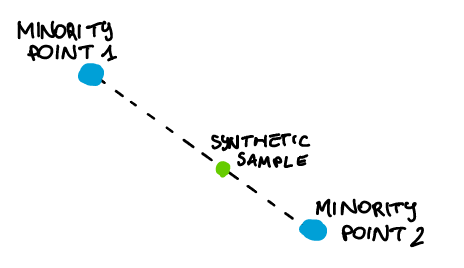
Obviously there are some drawbacks like non plausible data generation or the fact that the generated data point falls into a majority class region;
* **Undersampling:** as opposed to oversampling, this technique consists of sampling from the majority class so that it is represented by the same nnumber of samples. For example, if we are given class A with 100 samples and class B made up by 200 data points, undersampling consists of sampling 100 samples from class B (majority class). The natural drawback of this technique is that we are excluding some piece of information and this could lead to underfitting;
* **Adjust weights** in order to make a single sample of the minority class have an higher importance on the optimization process. For example, suppose class A has a half of the sample with respect to class B. We could double the weighs of class A, so that the overall influence of this class is the same as class B.

In [ ]:
s = df.Attrition_Flag

display(pd.DataFrame({"Count": s.value_counts().values,
              "Percentage": (s.value_counts(normalize = True).values * 100).round(2)
             },
             index = s.value_counts().index
            ))

del s

In [ ]:
# I am just dropping columns with non numerical atributes
# It is just a azy way to avoid errors in SMOTE procedure
# since it does not accept non numerical feature values

X, y = df.drop(["Attrition_Flag", 
                "CLIENTNUM", 
                "Gender",
                "Marital_Status",
                "Education_Level",
                "Card_Category",
                "Months_on_book",
                "Income_Category"
               ], axis = 1), df["Attrition_Flag"]

In [ ]:
sm = SMOTE()

X_resample, y_resample = sm.fit_resample(X, y)

In [ ]:
print("=" * 10 + " Before resampling " + "=" * 10)
print(f"Number of non attrited samples: {(y == 0).sum()} ")
print(f"Number of attrited samples: {(y == 1).sum()} ")

print("\n" + "=" * 10 + " After resampling " + "=" * 10)

print(f"Number of non attrited samples after SMOTE resampling: {(y_resample == 0).sum()} ")
print(f"Number of attrited samples after SMOTE resampling: {(y_resample == 1).sum()} ")

## <a id = "step5">Decision Tree Modelling</a>
<a style="font-size:12px;" href="#ToC">Back to Table of Contents</a>

As a first step, I would like to fit a predictive model that is also easy to intepret. By doing this. the results are easy to understand by business men as well. I decided to go with *Decision Tree* like models. In this section, you can find three models fitted under different hypothesis:
* Tree with max depth equal to three. This means that the result is made up by $2^3=8$ splitting rules. Thus the model is very easy to visualize and interpret, but it might not be the best as far as performance is concerned;
* A model with no depth limit. After training stage, it can be observed that this pipeline reaches [the best performance measures among the three models](#anchorTreeComparison);
* The last method uses no depth limit as above, but it provides imbalance handling. We should not expect this procedure to be the best in a general sense, like I used to do when I studied oversampling and undersampling. Actually, [the model after training performs worse than what has been obtained above](#anchorTreeComparison). Nevertheless, this pipeline allows to achieve a way better precision on the minority class (churned clients) and that is what we actually want from this project (we should focus on churned customer more than on esisting customer).

The last two models [reach an higher performance metric](#anchorTreeComparison), but it is [almost impossible to understand what happens under the hood](#NoIntrepretTree).

In [ ]:
X, y = df[["Avg_Utilization_Ratio", 
           "Total_Amt_Chng_Q4_Q1",
           "Total_Trans_Amt",
           "Total_Trans_Ct",
           "Total_Ct_Chng_Q4_Q1",
           "Total_Revolving_Bal",
           "Credit_Limit",
           "Contacts_Count_12_mon",
           "Income_Unknown",
           "Proportion_of_Credit",
           "Low_Products",
           "Blue_Card",
           "Gender_F"
          ]], df["Attrition_Flag"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [ ]:
clf = DecisionTreeClassifier(max_depth = 3)

clf.fit(X_train, y_train)

simple_tree = clf

In [ ]:
# Visualization of the Decision Tree

export_graphviz(clf, out_file="tree.dot", class_names=["Existing", "Churned"],feature_names= X.columns, impurity=False, filled=True)

!dot -Tpng tree.dot -o tree_limited.png -Gdpi=600

Image(filename = "tree_limited.png")

In [ ]:
clf = DecisionTreeClassifier()

params_grid = [
    {
        "ccp_alpha": np.arange(0, 0.02, 0.0002), 
        # I prefer using this as regularization parameter,
        # as suggested in the book "The Elements of Statistical Learning"
    }
]

grid = GridSearchCV(clf, 
                    param_grid = params_grid, 
                    scoring = "roc_auc")

grid.fit(X_train, y_train)

print(grid.best_params_)

clf = grid.best_estimator_

In [ ]:
pipe = Pipeline([
    ("balance_strategy", "passthrough"),
    ("classification", DecisionTreeClassifier())
])

params_grid = [
    {
           "balance_strategy": [SMOTE(), RandomOverSampler(), RandomUnderSampler()], # testing different oversamplig/undersampling techniques
            "classification__ccp_alpha": np.arange(0, 0.02, 0.0002), 
        # Like I said before, I prefer using this as regularization parameter,
        # as suggested in the book "The Elements of Statistical Learning"
    }
]

grid = GridSearchCV(pipe, 
                    param_grid = params_grid, 
                    scoring = "roc_auc")

grid.fit(X_train, y_train)

<a id = "NoIntrepretTree"></a>
<a style="font-size:12px;" href="#step5">Back to Tree Models Overview</a>

In [ ]:
# Visualization of the deeper decision tree

export_graphviz(grid.best_estimator_["classification"], out_file="tree.dot", class_names=["Existing", "Churned"],feature_names= X.columns, impurity=False, filled=True, proportion = False)

!dot -Tpng tree.dot -o tree_limited.png -Gdpi=600

Image(filename = "tree_limited.png")

### <a id = "AnchorTreeComparison">Model Comparison</a>
<a style="font-size:12px;" href="#step5">Back to Tree Models Overview</a>

In [ ]:
def plot_confusion_matrix(model, ipt, y_true):

    ax = sns.heatmap(pd.crosstab(y_true, model.predict(ipt)),
                annot = True,
                fmt = ".0f",
                cmap = "Blues",
                cbar = False,
                xticklabels = ["Existing", "Attrited"],
                yticklabels = ["Existing", "Attrited"],
                annot_kws={"size":15}
               )

    plt.xlabel("Predicted", size = 18)
    plt.ylabel("True", size = 18)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    plt.show()

In [ ]:
print("="*10 + "Tree with max depth equals 3 " + "=" * 10 + "\n")

print(f1_score(y_test, simple_tree.predict(X_test)))
print(round(100 * accuracy_score(y_test, simple_tree.predict(X_test)), 2))
print("\nPlotting confusion Matrix")
plot_confusion_matrix(simple_tree, X_test, y_test)


print("="*10 + "Tree without imbalance management " + "=" * 10 + "\n")

print(f1_score(y_test, clf.predict(X_test)))
print(round(100 * accuracy_score(y_test, clf.predict(X_test)), 2))
print("\nPlotting confusion Matrix")
plot_confusion_matrix(clf, X_test, y_test)

print("\n" + "=" * 10 + "Tree with imbalance management " + "=" * 10 + "\n")

print(f1_score(y_test, grid.best_estimator_["classification"].predict(X_test)))
print(round(100 * accuracy_score(y_test, grid.best_estimator_["classification"].predict(X_test)), 2))
print("\nPlotting confusion Matrix")
plot_confusion_matrix(grid.best_estimator_["classification"], X_test, y_test)

## <a id = "step6">XGBoost Modeling</a>
<a style="font-size:12px;" href="#ToC">Back to Table of Contents</a>

The last section of this notebook is about XGBoost, one of the best performing algorithms in Machine Learning. Using a simple parameter grid cross validation, it is possible to find an hyperparameter setup that massively improves the results achieved in the last section. This is fine, especially for predicting churn prone clients in advance. However, XGBoost is one of the so called *black box models*, since it is almost impossible to interpret the results because of its intrinsic complexity. What  makes it so hard to understand is that it is an ensemble method (it exploits a number, in our case 600, of *base learners*) and in a broad sense, the decision of the model is based on many small models.  
This is not only frustrating from a data scientist point of view, but it could represent a major barrier, since not entirely knowing  what distinguishes a regular customer from a churn prone one could prevent from building an efficient retention campaign.

However in the latest years explainability theory has gone really far and we can take advantage of that. In particular, a subsection has been created with the purpose of understanding model's behaviour using SHAP (the most popular explainable AI algorithm since its publication in 2017).

In [ ]:
# preparing parameter grid for cross validation

params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

In [ ]:
# Initialize the XGBoost model

xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',
                    scale_pos_weight = (y_train == 0).sum()/(y_train == 1).sum(), # Scale the weights to handle classes imbalance
                    silent=True, nthread=1)

In [ ]:
# We perform cross validation with random search
# this is due to the fact that training an XGBoost takes time and experimental results showed that training the model on a random subsample

folds = 5
param_comb = 15

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, scoring='roc_auc', n_jobs=4, cv=skf.split(X_train, y_train), verbose=3, random_state=1001 )

random_search.fit(X_train, y_train)

In [ ]:
# Visualize the parameters of the best estimator

random_search.best_estimator_

In [ ]:
random_search.best_score_

In [ ]:
# Eventually, we can visualize the performance of the model on the test set

print(f1_score(y_test, random_search.best_estimator_.predict(X_test)))
print(round(100 * accuracy_score(y_test, random_search.best_estimator_.predict(X_test)), 2))

plot_confusion_matrix(random_search.best_estimator_, X_test, y_test)

sns.violinplot(np.where(y_test == 0, "Existing", "Churned"), random_search.best_estimator_.predict_proba(X_test)[:, 1])

#### Threshold tuning

In [ ]:
print(f"Percentage of existing customers with predicted churn probabiity greater than 20%: {(random_search.best_estimator_.predict_proba(X_test)[y_test == 0, 1] > 0.2).sum()/(y_test == 0).sum()}")
print(f"Percentage of existing customers with predicted churn probabiity smaller than 60%: {(random_search.best_estimator_.predict_proba(X_test)[y_test == 1, 1] < 0.6).sum()/(y_test == 1).sum()}")

In [ ]:
def threshold_tune(proba, y_test, t_arr, beta = 1):
    best_threshold, best_score = 0, 0
    for threshold in t_arr:
        score = fbeta_score(y_test, proba > threshold, beta = beta)
        if fbeta_score(y_test, proba > threshold, beta = beta) > best_score:
            best_threshold, best_score = threshold, score
            
    return best_threshold, best_score

# Here I fit the threshold of XGBoost model in orgderto get the best F1-Score.
# However, it is possible to use any other metrics for threshold tuning. 
# In particular in my working experience, I found that using an weighted F1-score is a good choice.
# In this case, maybe it is better to use an F1 score with beta lower than 1 (in order to have a 
# better recall, that is, detect as many churned prone clients as possible)
threshold, score = threshold_tune(random_search.best_estimator_.predict_proba(X_train)[:, 1], y_train, np.arange(0, 1, 0.01))

In [ ]:
print(f"Threshold found: {threshold}")

ax = sns.heatmap(pd.crosstab(y_test, random_search.best_estimator_.predict_proba(X_test)[:, 1] > threshold),
            annot = True,
            fmt = ".0f",
            cmap = "Blues",
            cbar = False,
            xticklabels = ["Existing", "Attrited"],
            yticklabels = ["Existing", "Attrited"],
            annot_kws={"size":15}
           )

plt.title(f"Confusion matrix with threshold value {threshold}", fontsize = 18)
plt.xlabel("Predicted", size = 18)
plt.ylabel("True", size = 18)
ax.xaxis.tick_top()
ax.xaxis.set_label_position('top')
plt.show()

print(f"Accuracy with the tuned threshold: {round(100 * accuracy_score(y_test, random_search.best_estimator_.predict_proba(X_test)[:, 1] > threshold), 2)}")

### <a id = "step6.1">XGBoost Explanation</a>
<a style="font-size:12px;" href="#ToC">Back to Table of Contents</a>

First of all, it is important to understand what SHAP is. SHAP is an algorithm, based on game theory, that allows to understand the role of every single feature in predicting any (single) observation (technically, it is said to be a local explanator). In practice, given a single data point, this algorithm associates a weight (called *shapely value*) to each variable. These values can be considered as the contribution of the corresponding feature in computing the output. In other words, the sum of these values determines uniquely the output value: $$f(x)=\mathbb{E}[f]+\sum_{i = 1}^{p}\phi_{i, x}$$ where $\phi_{i, x}$ is the shapely value for the point $x$ associated with feature $i$.

This is a wonderful result and, by calculating shapely values for every observation, we can understand the role of each variable in our XGBoost model. Moreover, we could aggregate these values to get global interpretability. For example, in this section we visualize the feature importance bar plot, computed as follows: $$I_i=\sum_{k=1}^{N}\mid\phi_{i,x_k}\mid$$ We are also going to visualize:
* [**summary plot:**](#summary) it is a set of horizontal scatter plots, where each level is associated with a variable and it shows the shapely values for that particular feature. Moreover, each point is coloured through a gradient color, and this should determine the value of the feature (even though, I must admit, it is not always clear to me);
* [**dependence_plot:**](#dependence) it shows the behaviour of shapely values as a function of a singular feature (specified as input);
* **single point interpretation plot:** provides a graphical visualization of shapely value for a single observation (it may be usefl to understand some tricky data, like misclassification points). In this notebook a [*forge plot*](#forge) has been usd, but one other nice alternative option is the so called [*waterfall plot*](https://shap.readthedocs.io/en/latest/generated/shap.plots.waterfall.html#shap.plots.waterfall)

**Should I use train or test data for model explanation?** I suggest reading [this page](https://christophm.github.io/interpretable-ml-book/feature-importance.html) (I know, it is referred to other feature importance methods, but the concept is universal). However, in [this discussion](https://github.com/slundberg/shap/issues/259) the author of SHAP states that this method is often used for with data. Thus in this section, I work with test data only.

<span style="font-size:16px;color:Green"><b>WHAT CAN BE NOTICED</b></span>

From the feature importance plot we can gain an high level intuition of what is happening inside XGBoost model. As noticed with the simple tree learner, the total number of transactions and their amount are the most important features. Now, let's look at the summary plot for a moment: we can immediately see that *Total_Trans_Ct* is the most influent variable in predicting an *existing customer* by far. In particular, when a customer makes a lot of transactions, its probability of being an *existing* customer increases a lot. However, when classifying *churned* clients comes into place, the power of this variable is outperformed by the amount of transactions and other variables (like change in the amount of transactions, low number of products, high number of contacts). But, now, can we say that transactions amount is the most informative variable in prediction churned or prone to churn clients? Here comes the funny part. Let's have a look at the dependence plot. We can notice that SHAP impact magnitude on the output is high for *Total_Trans_Amt* only when this variable assumes a very low value or when it is around 7500 (oh, that is strange; we should investigate with a business expert). Many other variables are more smoother and have an unique interpretation. In general the following churn *risk indicators* (variable values associated with an high SHAP magnitude) can be detected by looking at [**dependence_plot:**](#dependence)
* Low number of transactions;
* 50% or less number/amount of transactions with respect to the last quarter;
* high value of contacts count (probably associated with complaints);
* low number of products (probably associated with non loyal clients); 
* very small or very high revolving balance.

In [ ]:
# Feature Importance

shap_explainer = shap.TreeExplainer(random_search.best_estimator_)
shap_values = shap_explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

<a id = "summary">Summary Plot</a>

In [ ]:
f = plt.figure()

shap.summary_plot(shap_values, X_test)
f.savefig("/summary_plot1.png", bbox_inches='tight', dpi=600)

<a id = "dependence">Dependence Plot Analysis</a>

In [ ]:
for i in ["Avg_Utilization_Ratio", 
           "Total_Amt_Chng_Q4_Q1",
           "Total_Trans_Amt",
           "Total_Trans_Ct",
           "Total_Ct_Chng_Q4_Q1",
           "Total_Revolving_Bal",
           "Credit_Limit",
           "Contacts_Count_12_mon",
           "Income_Unknown",
           "Proportion_of_Credit",
           "Low_Products",
           "Blue_Card",
           "Gender_F"
          ]:
    print(f"Dependence plot for variable {i}")
    shap.dependence_plot(i, shap_values, X_test)
    plt.show()

In [ ]:
df.loc[df.Avg_Utilization_Ratio > 0.85, "Attrition_Flag"].value_counts(normalize = True)

In [ ]:
df.loc[(df.Avg_Utilization_Ratio < 0.8) & (df.Avg_Utilization_Ratio > 0.4), "Attrition_Flag"].value_counts(normalize = True)

In [ ]:
pd.set_option("display.max_columns", 25)
display(df[(df.Avg_Utilization_Ratio > 0.85) & (df.Attrition_Flag == 1)].head())

pd.reset_option("display.max_columns")

In [ ]:
y_pred = random_search.best_estimator_.predict(X_test)

In the last two cells of this notebook, I want to show some *error data*. In particular, I am showing a local explanation of a misclassified sample and 10 rows of misclassification dataset. Misclassification seems acceptable to me (many clients have an high number of contacts, low number of transactions and almost every customer has decreased its credit card utilization).

However, again, it would be important to compare these results with business expert insights, in order to understand whether these results are ok and these are actual churn prone clients or false positives.

<a id = "forge">Forge Plot</a>

In [ ]:
type_one_shap = shap_values[(y_pred == 1) & (y_test == 0)]
type_one_input = X_test.values[(y_pred == 1) & (y_test == 0)]

shap.initjs()
shap.force_plot(shap_explainer.expected_value, type_one_shap[0], type_one_input[0], feature_names = X_test.columns)

<a id = "typeIerror"></a>

In [ ]:
X_test[(y_pred == 1) & (y_test == 0)]